In [53]:
from core.gradient_descent import wolfe_conditions_search, point_number_terminate_condition
%load_ext autoreload
%autoreload 2

from core.high_order_optimization import *
from core.optimizer_evaluator import *
from core.utils import *
from core.visualizer import *
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
f1 = lambda x: np.exp(x[0])
f2 = lambda x: np.sin(x[0])
f3 = lambda x: np.exp(-(x[0] + 1))
fs = [f1, f2, f3]

df1 = lambda x: np.array([np.exp(x[0])])
df2 = lambda x: np.array([np.cos(x[0])])
df3 = lambda x: np.array([-np.exp(-(x[0] + 1))])
dfs = [df1, df2, df3]

x0 = np.array([10])

termination = lambda f, points: len(points) > 20

p1 = gauss_newton(fs, dfs, x0, termination)
p2 = gauss_newton_with_approx_grad(fs, x0, termination)

print(f"symbolic grad argmin = {p1[-1]}, approx grad argmin = {p2[-1]}")

symbolic grad argmin = [-0.30823297], approx grad argmin = [-0.3083785]


# Вычисление гессианы: Аналитически, численно

In [55]:
q = QuadraticForm(np.array([
    [10, 2],
    [2, 5]
                  ]))

In [56]:
x = np.array([3, 4])
q.gradient_function()(x)

array([76, 52])

In [57]:
symmetric_gradient_computer(q)(x)

array([76., 52.])

In [58]:
q.hessian_function()(x)

array([[20,  4],
       [ 4, 10]])

In [59]:
symmetric_hessian_computer(q)(x)

array([[19.9999306 ,  3.99992928],
       [ 3.99992928,  9.9999653 ]])

# Метод Ньютона

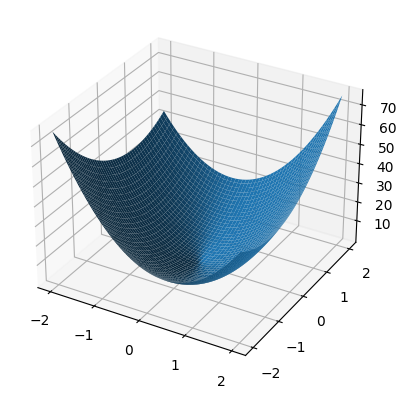

In [60]:
roi = SearchRegion2d((-2, 2), (-2, 2))
visualize_function_3d(q, roi)

Best value found: x* = [-1.30923418e-09  8.72822784e-10] with f(x*) = 1.637912166452465e-17


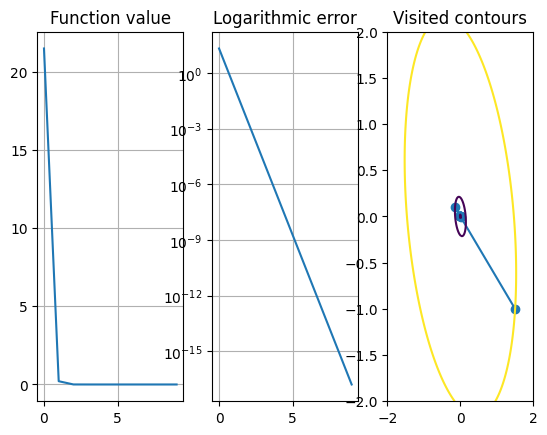

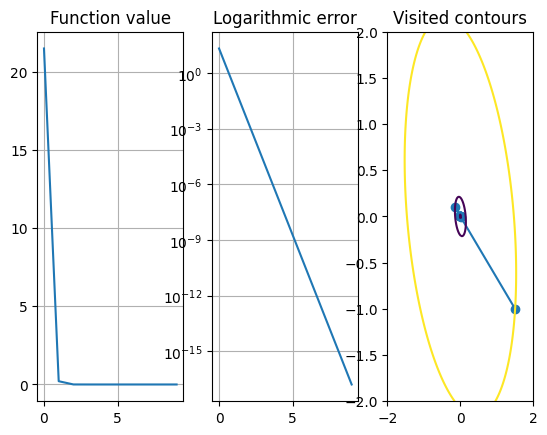

In [61]:
visualize_optimizing_process(q, roi, np.array(newton_optimize(
    q, q.gradient_function(), GivenInverseHessianController(lambda x: np.linalg.inv(q.hessian_function()(x))), np.array([1.5, -1.]), wolfe_conditions_search(0.1, 0.9), point_number_terminate_condition(10)
)), 0)

Достаточно ≈11 итераций для матрицы со сколь угодно большим числом обусловленности

In [62]:
form = generate_positive_definite_quadratic_form(2000, 1000, random_orthonormal_basis)
form

QuadraticForm(matrix=array([[484.65070292,   4.95493092, -11.79441628, ...,   0.83464637,
         14.77784206,  -7.83964243],
       [  4.95493092, 499.0659218 ,  14.33501418, ...,   1.79267305,
         -3.04182744,   0.80901088],
       [-11.79441628,  14.33501418, 496.16886833, ...,   1.45599234,
          3.09189803,   4.4302962 ],
       ...,
       [  0.83464637,   1.79267305,   1.45599234, ..., 511.22109989,
          7.9908385 ,   6.38657359],
       [ 14.77784206,  -3.04182744,   3.09189803, ...,   7.9908385 ,
        490.86374046,   6.03203682],
       [ -7.83964243,   0.80901088,   4.4302962 , ...,   6.38657359,
          6.03203682, 505.87557354]]))

In [63]:
points = newton_optimize(form, form.gradient_function(), GivenInverseHessianController(lambda x: np.linalg.inv(form.hessian_function()(x))), random_normalized_vector(form.n), wolfe_conditions_search(0.1, 0.9),
                         precision_termination_condition)

points

[array([0.02071292, 0.0115014 , 0.01739346, ..., 0.02317339, 0.02859535,
        0.0264509 ]),
 array([-0.00204022, -0.00113289, -0.00171326, ..., -0.00228258,
        -0.00281664, -0.00260541]),
 array([0.00020096, 0.00011159, 0.00016876, ..., 0.00022483, 0.00027744,
        0.00025663]),
 array([-1.97947472e-05, -1.09915617e-05, -1.66224380e-05, ...,
        -2.21461556e-05, -2.73277690e-05, -2.52783757e-05]),
 array([1.94978259e-06, 1.08266883e-06, 1.63731014e-06, ...,
        2.18139633e-06, 2.69178525e-06, 2.48992001e-06]),
 array([-1.92053586e-07, -1.06642879e-07, -1.61275049e-07, ...,
        -2.14867539e-07, -2.65140847e-07, -2.45257121e-07]),
 array([1.89172782e-08, 1.05043236e-08, 1.58855923e-08, ...,
        2.11644525e-08, 2.61163734e-08, 2.41578264e-08]),
 array([-1.86335190e-09, -1.03467588e-09, -1.56473085e-09, ...,
        -2.08469858e-09, -2.57246278e-09, -2.37954590e-09]),
 array([1.83540162e-10, 1.01915574e-10, 1.54125988e-10, ...,
        2.05342810e-10, 2.53387584e

In [64]:
len(points)

11

In [65]:
[form(p) for p in points]

[230.6609392331335,
 2.2379300976746537,
 0.02171295729016419,
 0.00021066453986849507,
 2.0439200319391033e-06,
 1.9830623129881355e-08,
 1.9240166326189028e-10,
 1.8667290373826994e-12,
 1.811147180294649e-14,
 1.7572202730013872e-16,
 1.704899039372785e-18]